<a href="https://colab.research.google.com/github/raunaksatone5/ML-Deployment-Sentimental-Analysis-Case-Study/blob/main/Sentimental_Analysis_Case_Study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ML deployment: A Sentimental Analysis Case Study

## Loading the dataset

In [1]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dataset/movie_data.csv')
df.head(10)

,review,sentiment
0,"In 1974, the teenager Martha Moxley (Maggie Gr...",1
1,OK... so... I really like Kris Kristofferson a...,0
2,"***SPOILER*** Do not read this, if you think a...",0
3,hi for all the people who have seen this wonde...,1
4,"I recently bought the DVD, forgetting just how...",0
5,Leave it to Braik to put on a good show. Final...,1
6,Nathan Detroit (Frank Sinatra) is the manager ...,1
7,"To understand ""Crash Course"" in the right cont...",1
8,I've been impressed with Chavez's stance again...,1
9,This movie is directed by Renny Harlin the fin...,1


### Getting a hang of CountVectorizer and TfIdfVectorizer

* CountVectorizer

In [2]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer()
docs = (['Roses are Red',
         'The sky is blue',
         'Roses are Red, The sky is blue, sum of one and one is two'])
bag = count.fit_transform(docs)

print(count.vocabulary_)
print(bag.toarray())

{'roses': 7, 'are': 1, 'red': 6, 'the': 10, 'sky': 8, 'is': 3, 'blue': 2, 'sum': 9, 'of': 4, 'one': 5, 'and': 0, 'two': 11}
[[0 1 0 0 0 0 1 1 0 0 0 0]
 [0 0 1 1 0 0 0 0 1 0 1 0]
 [1 1 1 2 1 2 1 1 1 1 1 1]]


* TfIdfVectorizer

In [3]:
from sklearn.feature_extraction.text import TfidfTransformer
np.set_printoptions(precision=2)

tfidf = TfidfTransformer(use_idf=True, norm='l2', smooth_idf=True)

print(tfidf.fit_transform(bag).toarray())

[[0.   0.58 0.   0.   0.   0.   0.58 0.58 0.   0.   0.   0.  ]
 [0.   0.   0.5  0.5  0.   0.   0.   0.   0.5  0.   0.5  0.  ]
 [0.27 0.2  0.2  0.41 0.27 0.54 0.2  0.2  0.2  0.27 0.2  0.27]]


### Data Cleaning


In [4]:
import re
def preprocessor(text):
  text =re.sub('<[^>]*>', '', text)
  emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
  text = re.sub('[\W]+', ' ', text.lower()) + ' '.join(emoticons).replace('-', '')
  
  return text
preprocessor("Testing out a :) sentence to preprocess :-( !")

'testing out a sentence to preprocess :) :('

In [5]:
# preprocess review column
df['review'] = df['review'].apply(preprocessor)

### Text Data transformation into TF-IDF Vectors


In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(strip_accents=None,
                         lowercase=True,
                         preprocessor=None,  # Need not apply as it is already applied during Data Cleaning
                         use_idf=True,
                         norm='l2',
                         smooth_idf=True)

y = df.sentiment.values
X = tfidf.fit_transform(df.review)

### Classifying reviews using Logistic Regression

In [7]:
from sklearn.model_selection import train_test_split
import pickle
from sklearn.linear_model import LogisticRegressionCV


X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.5, shuffle=False)

clf = LogisticRegressionCV(cv=5,
                           scoring='accuracy',
                           random_state=0,
                           n_jobs=-1,
                           verbose=3,max_iter=300).fit(X_train, y_train)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.7min finished


### Evaluating the model


In [8]:
clf.score(X_test, y_test)

0.897

### Plotting the Confusion Matrix for the test data


In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


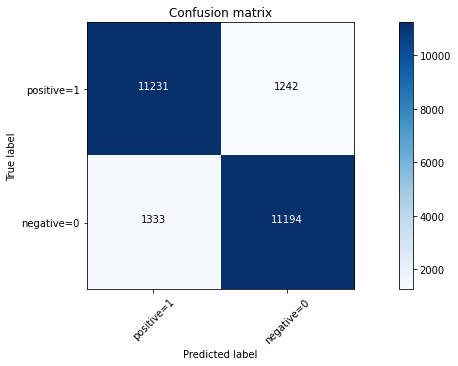

In [11]:
yhat = clf.predict(X_test)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=[1,0])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure(figsize=(13,5))
plot_confusion_matrix(cnf_matrix, classes=['positive=1','negative=0'],normalize= False,  title='Confusion matrix')


## Pipeline, Flask and API



### Saving the model(s) built

In [12]:

import pickle

#Dumping the Tfidf model built

with open('tfidf_imdb.pkl', 'wb') as file_output:
    pickle.dump(tfidf, file_output)

##############################################################

#Dumping the sentiment analysis model built

with open('mle_deployment_senti_model.pkl', 'wb') as file_output:
    pickle.dump(clf, file_output)

In [13]:
mle = pickle.load(open('mle_deployment_senti_model.pkl','rb'))
tfidf_vect = pickle.load(open('tfidf_imdb.pkl','rb'))



data = ["movie is an awesome movie"]
vect = tfidf_vect.transform(data).toarray()
my_prediction = mle.predict(vect)
print(my_prediction)

data = ["movie is a bad movie"]
vect = tfidf_vect.transform(data).toarray()
my_prediction = mle.predict(vect)
print(my_prediction)

[1]
[0]
